# Analyse d'opinion

#### Objectif : créer une chaine de traitement des données textuelles sur l'analyse d'opinion

#### Jeu de données : revues de films


* Analyses obligatoires
    * Comparer les performances avec différents pré-traitements
        * e.g Taille de vocabulaire, unigram/bigram, Stemming, ...
    * Implémenter un post-traitement ???
    * Appliquer les traitements optimaux sur les données de test et sauver les résultats dans un fichier txt


* Compléments optionnels
    * Analyser les performances avec Word2Vec, en utilisant des stratégies d'agrégation naïves

* Ecrire un rapport succinct
    * Présentant les courbes de perfornces pour les paramètres les plus influents/marquants
    * Quelques conclusions sur le travail effectué

  
* Soumettre par mail:
    * Rapport, Notebook(s), 2 fichiers de scores_model_model_model_model_model_model_model_model_model_model_model_model_model_model (locuteur/opinion)

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [27]:
path = "movies/movies1000/"

## Exploration des données

Le dossier movies est subdivisé en 2 sous-dossiers contenant les textes classifiés comme positifs et négatifs. La fonction load_files permet de charger les textes et les labels associés.

In [28]:
def load_movies(path2data):  # 1 classe par répertoire
    alltxts = []  # init vide
    labs = []
    cpt = 0
    for cl in os.listdir(path2data):  # parcours des fichiers d'un répertoire
        for f in os.listdir(path2data + cl):
            txt = open(path2data + cl + "/" + f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt += 1  # chg répertoire = cht classe
    return alltxts, labs

On vérifie au préalable que le plan de l'expérience est bien équilibré. C'est le cas ici, donc pas besoin d'adopter des stratégies de rééquilibrage/pondération.

In [29]:
all_texts, all_labels = load_movies(path)

neg, pos = np.unique(all_labels, return_counts=True)[1]
print(f"Il y a {neg/(neg+pos) * 100} % de commentaires négatifs")

Il y a 50.0 % de commentaires négatifs


Dans un but premièrement purement exploratoire, je vais utiliser la librairie NLTK pour extraire les mots les plus fréquents.

Je retire les stopwords ainsi que la ponctuation pour ne garder que les mots les plus significatifs.

Le but était surtout de voir si les mots les plus fréquents étaient des mots qui avaient un sens pour moi dans le cadre de cette analyse de sentiments. Sans utiliser le filtrage sur stopwords, le registre des mots les plus fréquents est de manière intuitive très peu informatif. Dans le pipeline de traitement, il faudra donc préféréntiellement retirer les stopwords. 

On remarque que certains mots très proches comme `character` et `characters` sont comptés comme deux mots différents. Il faudra donc également faire attention à la lemmatisation des mots (stemming).

In [30]:
import nltk
import string

from nltk import bigrams, trigrams, FreqDist, word_tokenize
from nltk.corpus import stopwords

# Nécessaire pour la première exécution !!!
nltk.download("punkt")
nltk.download("stopwords")

all_texts, all_labels = load_movies(path)

text = " ".join([str(elem) for elem in all_texts])

# Retire la ponctuation
translator = str.maketrans("", "", string.punctuation)
text = text.translate(translator)

tokens = word_tokenize(text)

# Filtre les stopwords
stop_words = set(stopwords.words("english"))
tokens = list(filter(lambda token: token not in stop_words, tokens))

freq_dist = FreqDist(tokens)
vocab_size = len(freq_dist)
print(f"Taille du vocabulaire : {vocab_size}")

# Calcule les 100 bigrams et trigrams les plus fréquents
bigrams = list(bigrams(tokens))
trigrams = list(trigrams(tokens))

bigram_freq = FreqDist(bigrams)
trigram_freq = FreqDist(trigrams)

top_100_bigrams = bigram_freq.most_common(100)
top_100_trigrams = trigram_freq.most_common(100)

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Taille du vocabulaire : 47420


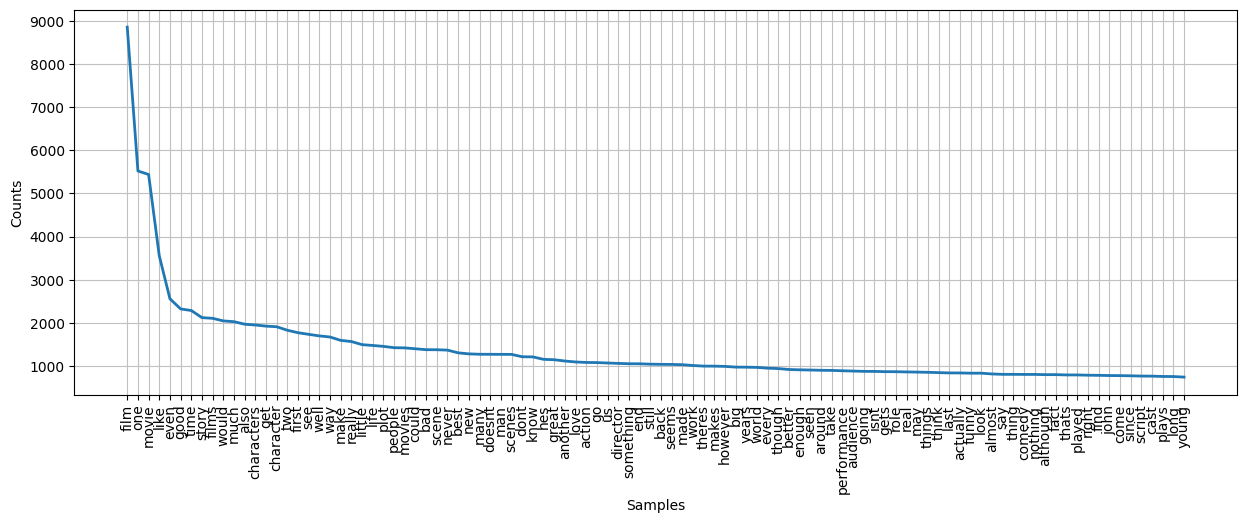

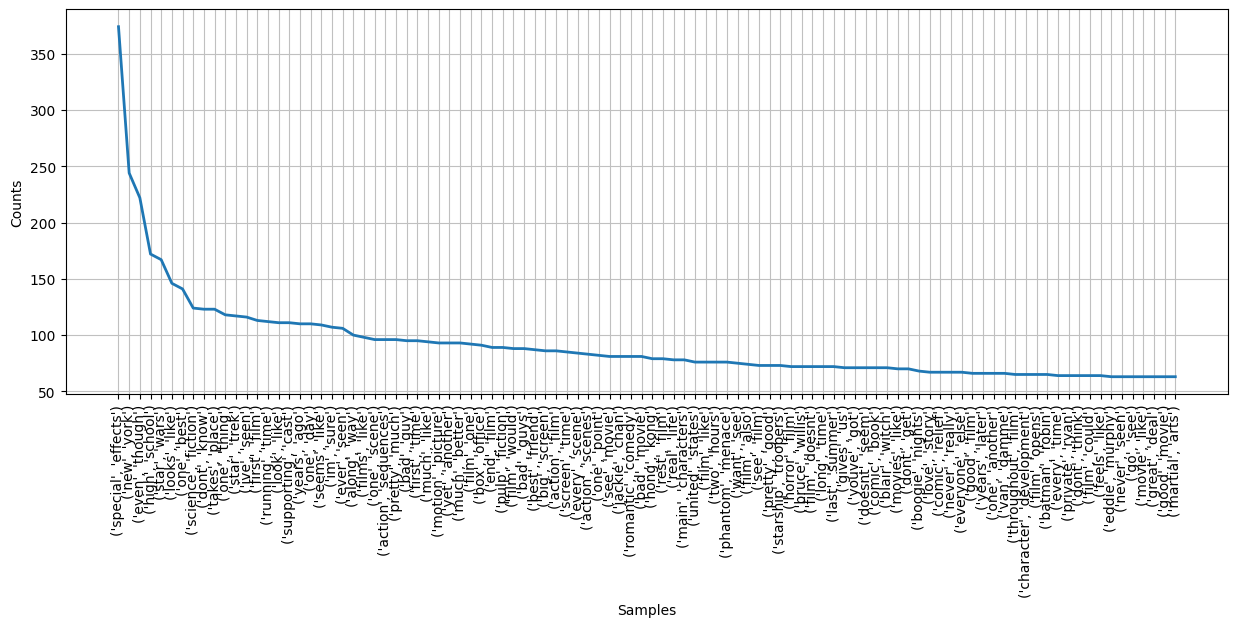

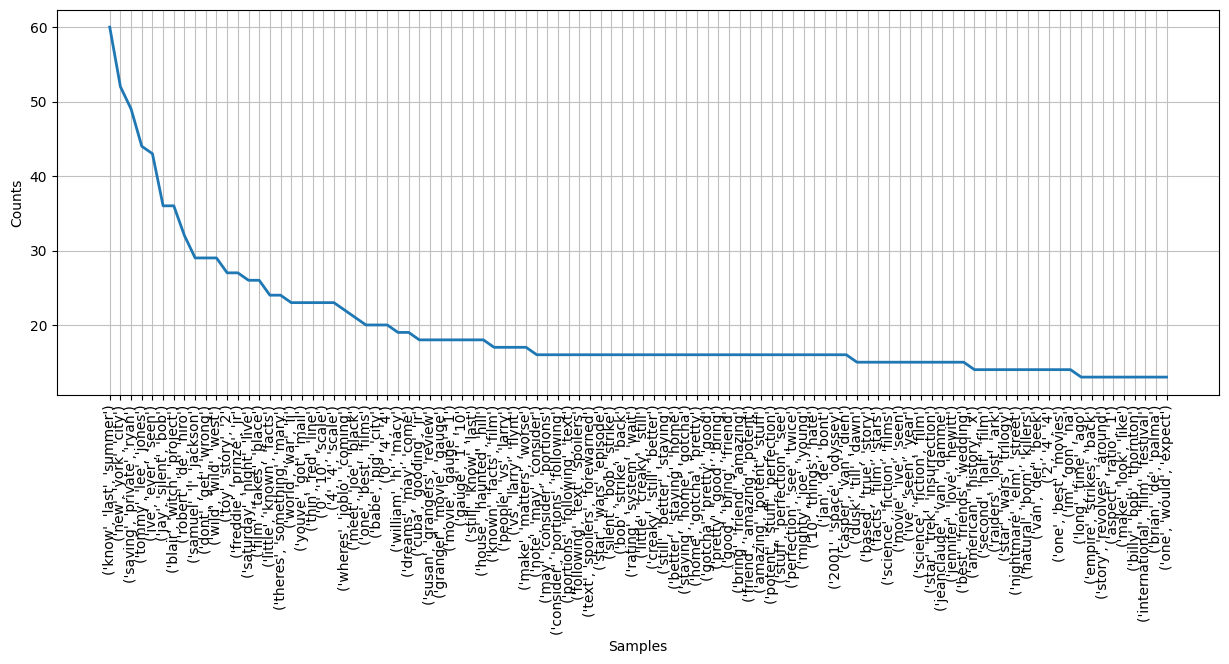

In [31]:
plt.figure(figsize=(15, 5))
freq_dist.plot(100)
plt.show()

plt.figure(figsize=(15, 5))
bigram_freq.plot(100)
plt.show()

plt.figure(figsize=(15, 5))
trigram_freq.plot(100)
plt.show()

## Architecture du modèle

On divise les données en deux parties : une partie pour l'apprentissage et une partie pour le test.

In [32]:
from sklearn.model_selection import train_test_split

all_texts, all_labels = load_movies(path)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    all_texts, all_labels, test_size=0.2, random_state=0
)

print("Taille de l'ensemble d'entraînement :", len(train_texts))
print("Taille de l'ensemble de test :", len(test_texts))

Taille de l'ensemble d'entraînement : 1600
Taille de l'ensemble de test : 400


Avec un dummy classifier on va poser une baseline pour notre modèle.
Si notre modèle est moins bon que le dummy classifier ou meilleur de peu, alors il ne sert à rien.

In [33]:
# make a dummy classifier always predicting the most frequent class
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_texts, train_labels)
preds = dummy_clf.predict(test_texts)
print("Accuracy:", accuracy_score(test_labels, preds))

Accuracy: 0.5


Il faut permettre au pipeline de changer de modèle, de paramètres, de pré-traitement, etc. pour trouver le meilleur modèle.

Par exemple, en première intuition on peut imaginer qu'en gardant la ponctuation il faille utiliser un bigramme/trigramme etc pour avoir de meilleures performances. Reste à le montrer. 

In [51]:
# import outils de preprocessing
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

# import models
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from functools import partial
from unidecode import unidecode


def preprocess(text, remove_punctuation=True, use_stemming=True, remove_stopwords=True):
    # En anglais, à priori les accents et autres caractères spéciaux ne sont très utiles
    # dans ce contexte, je normalise donc le texte
    text = text.lower()
    text = unidecode(text)

    tokens = nltk.word_tokenize(text)

    if remove_punctuation:
        tokens = [token for token in tokens if token not in string.punctuation]

    if remove_stopwords:
        stop_words = set(stopwords.words("english"))
        tokens = [token for token in tokens if token not in stop_words]

    if use_stemming:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]

    return " ".join(tokens)


with_punctuation = partial(preprocess, remove_punctuation=False)

# Définir une pipeline avec différentes étapes de pré-traitement
pipeline = Pipeline(
    [
        (
            "vect",
            CountVectorizer(
                preprocessor=preprocess,
                ngram_range=(1, 1),
            ),
        ),
        ("tfidf", TfidfTransformer()),
        ("clf", SVC()),
    ]
)

Je vérifie que le pré-traitement fonctionne bien sur des exemples simples:

Les mots sont bien lemmatisés, les stopwords sont bien retirés, la ponctuation est bien retirée/gardée selon le paramètre.

In [52]:
from functools import partial

# partial me permet de créer une fonction qui appelle preprocess avec certains paramètres

without_punctuation = partial(preprocess, remove_punctuation=True)
sample_text = "This is a sample text, with punctuation, accents comme à l'époque  !"
print(f"Text with punctuation: {sample_text}")
print(f"Text without punctuation: {without_punctuation(sample_text)}")

Text with punctuation: This is a sample text, with punctuation, accents comme à l'époque  !
Text without punctuation: sampl text punctuat accent comm l'epoqu


In [53]:
from sklearn.metrics import accuracy_score

pipeline.fit(train_texts, train_labels)
predictions = pipeline.predict(test_texts)
accuracy = accuracy_score(test_labels, predictions)

print("Précision du modèle :", accuracy)

Précision du modèle : 0.7725


## Evaluation des modèles

Comme il existe de nombreux paramètres, pour faire une comparaison pertinente je préfère sélectionner certains paramètres à investiguer plus que d'autres au fur et à mesure que j'avance dans l'analyse.

### Famille de modèles

In [37]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
import pandas as pd

# Définir les modèles à tester
models = [
    ("dummy", DummyClassifier(strategy="most_frequent")),
    ("SVM", SVC()),
    ("Logistic Regression", LogisticRegression()),
    ("Gradient Boosting", GradientBoostingClassifier()),
]

# Définir les pipelines à tester
pipelines = [
    Pipeline(
        [
            (
                "vect",
                CountVectorizer(
                    preprocessor=preprocess,
                    ngram_range=(1, 1),
                ),
            ),
            ("tfidf", TfidfTransformer()),
            ("clf", model),
        ]
    )
    for _, model in models
]

models += [("SVM (without TF-IDF)", SVC())]
pipelines += [
    Pipeline([("vect", CountVectorizer(preprocessor=preprocess)), ("clf", SVC())])
]

# Définir les scores à utiliser
scoring = ["accuracy", "f1_macro"]
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# Calculer les scores pour chaque pipeline (f1 et accuracy) pour en faire
# un boxplot ensuite
scores_model = []

for pipeline, (name, _) in zip(pipelines, models):
    print(f"Calcul des scores pour {name}")
    results = cross_validate(
        pipeline,
        all_texts,
        all_labels,
        cv=kfold,
        scoring=scoring,
        return_train_score=True,
    )
    for score in scoring:
        for fold in range(5):
            scores_model.append(
                {
                    "score": results[f"test_{score}"][fold],
                    "train_score": results[f"train_{score}"][fold],
                    "fold": fold,
                    "model": name,
                    "score_name": score,
                }
            )

Calcul des scores pour dummy


Calcul des scores pour SVM
Calcul des scores pour Logistic Regression
Calcul des scores pour Gradient Boosting
Calcul des scores pour SVM (without TF-IDF)


In [58]:
import seaborn as sns


def plot_scores(scores, modalites):
    df = pd.DataFrame(scores)

    accuracy = df[df["score_name"] == "accuracy"]
    f1 = df[df["score_name"] == "f1_macro"]

    accuracy.boxplot(column="score", by="model", figsize=(12, 6))
    plt.title(f"Boxplot de l'Accuracy par {modalites}")
    plt.suptitle("")
    plt.savefig(f"figures/boxplot_accuracy_{modalites}.png")
    plt.show()

    f1.boxplot(column="score", by="model", figsize=(12, 6))
    plt.title(f"Boxplot du F1 par {modalites}")
    plt.suptitle("")
    plt.savefig(f"figures/boxplot_f1_{modalites}.png")
    plt.show()

In [59]:
plot_scores(scores_model, "modele")

NameError: name 'scores_model' is not defined

Le SVM avec TF-IDF a des performances très bonnes, avec les quartiles plus proches de la moyenne que les autres, quasi similairement avec la logistic regression. Assez étonnement le gradient boosting sous performe. Il faudrait dans l'idéal se renseigner dans la littérature s'il est nécessaire d'ajouter une étape dans le pipeline pour améliorer ses performances.

### Influence du preprocessing

In [56]:
keep_punctuation = partial(preprocess, remove_punctuation=False)
keep_stopwords = partial(preprocess, remove_stopwords=False)
without_stemming = partial(preprocess, use_stemming=False)
quasi_non_preprocess = partial(
    preprocess, remove_punctuation=False, remove_stopwords=False, use_stemming=False
)

# Définir les modèles à tester
model = SVC()
preprocessors = [
    ("SVM with all", preprocess),
    ("SVM (without extra preprocessing)", quasi_non_preprocess),
    ("SVM (keep punctuation)", keep_punctuation),
    ("SVM (keep stopwords)", keep_stopwords),
    ("SVM (without stemming)", without_stemming),
]

# Définir les pipelines à tester
pipelines = [
    Pipeline(
        [
            (
                "vect",
                CountVectorizer(
                    preprocessor=preprocessor,
                    ngram_range=(1, 1),
                ),
            ),
            ("tfidf", TfidfTransformer()),
            ("clf", model),
        ]
    )
    for _, preprocessor, in preprocessors
]

# Définir les scores à utiliser
scoring = ["accuracy", "f1_macro"]
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# Calculer les scores pour chaque pipeline (f1 et accuracy) pour en faire
# un boxplot ensuite
scores_preprocessor = []

for pipeline, (name, _) in zip(pipelines, preprocessors):
    print(f"Calcul des scores pour {name}")
    results = cross_validate(
        pipeline,
        all_texts,
        all_labels,
        cv=kfold,
        scoring=scoring,
        return_train_score=True,
    )
    for score in scoring:
        for fold in range(5):
            scores_preprocessor.append(
                {
                    "score": results[f"test_{score}"][fold],
                    "train_score": results[f"train_{score}"][fold],
                    "fold": fold,
                    "model": name,
                    "score_name": score,
                }
            )

Calcul des scores pour SVM with all
Calcul des scores pour SVM (without extra preprocessing)
Calcul des scores pour SVM (keep punctuation)
Calcul des scores pour SVM (keep stopwords)
Calcul des scores pour SVM (without stemming)


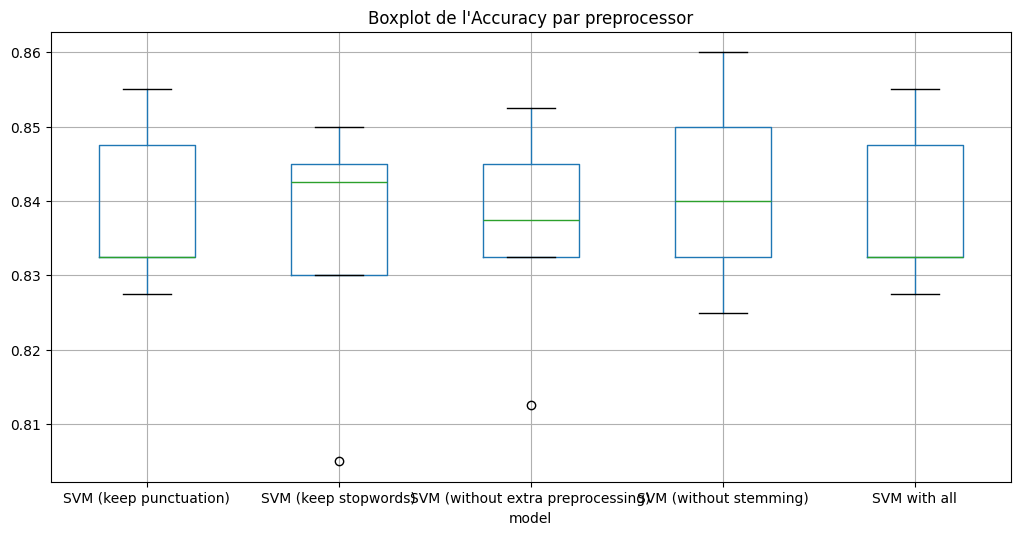

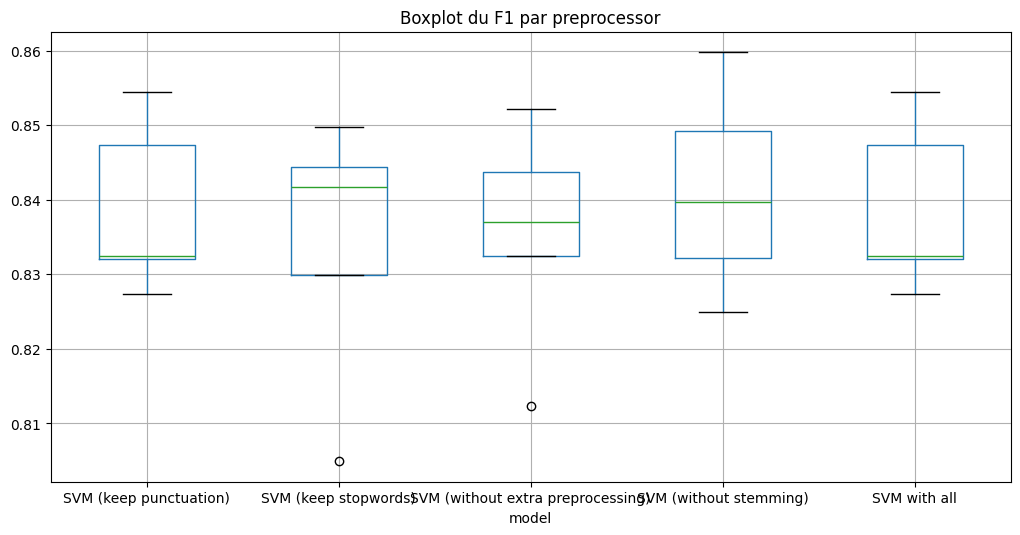

In [60]:
plot_scores(scores_preprocessor, "preprocessor")

On constate que dans notre cas retirer le stemming peut être marginalement bénéfique. 

Ce résultat dénote surtout de l'importance des stopwords dans notre cas d'usage, il semble que cela soit le paramètre le plus important à prendre en compte : avec un ngram de 2 il y a une valeur inférieure en f1 et accuracy, forte dispersion, mais avec un ngram de 1 au contraire les résultats sont très bons.

**Ces résultats dépendent probablement fortement du ngrams**, seulement le temps de calcul est relativement conséquent. J'ai donc fait ces tests à côté et pas sur la procédure centrale.


Par exemple, avec tous les prétraitements et sans faire de cross validation :

In [61]:
scores_ngrams = []

for i in range(3):
    pipeline = Pipeline(
        [
            (
                "vect",
                CountVectorizer(
                    preprocessor=without_stemming,
                    ngram_range=(1, i + 1),
                ),
            ),
            ("tfidf", TfidfTransformer()),
            ("clf", SVC()),
        ]
    )

    results = cross_validate(
        pipeline,
        all_texts,
        all_labels,
        cv=kfold,
        scoring=scoring,
        return_train_score=True,
    )

    for score in scoring:
        for fold in range(5):
            scores_ngrams.append(
                {
                    "score": results[f"test_{score}"][fold],
                    "train_score": results[f"train_{score}"][fold],
                    "fold": fold,
                    "model": f"SVM (without stemming) - {i+1}grams",
                    "score_name": score,
                }
            )

In [67]:
plot_scores(scores_ngrams, "ngrams, sans stemming")

### GridSearch sur le SVM ?

Au lieu d'utiliser un gridsearch, on va passer par le TPE (Tree-structured Parzen Estimator) qui est un algorithme d'optimisation bayésienne. Il est implémenté dans la librairie optuna en paramètre par défaut.

Comme il y énormément de calculs à réaliser, on va paralléliser les cross validations. On compare les scores au regard de l'accuracy.

In [66]:
import optuna
from sklearn.model_selection import cross_val_score
from joblib import parallel_backend

def objective(trial):
    # Définir l'espace de recherche
    C = trial.suggest_loguniform('C', 1e-10, 1e10)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_loguniform('gamma', 1e-10, 1e10)

    # Créer le pipeline
    pipeline = Pipeline([
        ("vect", CountVectorizer(preprocessor=preprocess, ngram_range=(1, 1))),
        ("tfidf", TfidfTransformer()),
        ("clf", SVC(C=C, kernel=kernel, gamma=gamma))
    ])
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    # Calculer le score de validation croisée
    with parallel_backend('threading', n_jobs=-1):
        score = cross_val_score(pipeline, all_texts, all_labels, cv=kfold, scoring='accuracy').mean()

    return score

# Créer un study Optuna
study = optuna.create_study(direction='maximize', study_name='my_study', storage='sqlite:///my_study.db', load_if_exists=True)

# Exécuter l'optimisation
study.optimize(objective, n_trials=20, n_jobs=-1)

# Afficher les meilleurs hyperparamètres
print('Best hyperparameters: ', study.best_params)

[I 2024-01-08 21:31:12,136] Using an existing study with name 'my_study' instead of creating a new one.
/tmp/ipykernel_1130/1444486322.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-10, 1e10)
/tmp/ipykernel_1130/1444486322.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-10, 1e10)
[I 2024-01-08 21:34:00,619] Trial 4 finished with value: 0.8135 and parameters: {}. Best is trial 0 with value: 0.8135.


KeyboardInterrupt: 

[I 2024-01-08 21:34:10,029] Trial 6 finished with value: 0.8135 and parameters: {}. Best is trial 0 with value: 0.8135.
[I 2024-01-08 21:35:13,774] Trial 5 finished with value: 0.8135 and parameters: {}. Best is trial 0 with value: 0.8135.
--- Logging error ---
Traceback (most recent call last):
  File "/home/codespace/.python/current/lib/python3.10/logging/__init__.py", line 1103, in emit
    stream.write(msg + self.terminator)
  File "/home/codespace/.local/lib/python3.10/site-packages/ipykernel/iostream.py", line 662, in write
    self._schedule_flush()
  File "/home/codespace/.local/lib/python3.10/site-packages/ipykernel/iostream.py", line 559, in _schedule_flush
    self.pub_thread.schedule(_schedule_in_thread)
  File "/home/codespace/.local/lib/python3.10/site-packages/ipykernel/iostream.py", line 266, in schedule
    self._event_pipe.send(b"")
  File "/home/codespace/.local/lib/python3.10/site-packages/zmq/sugar/socket.py", line 696, in send
    return super().send(data, flags=f